In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!{"ros2 run local_planning_performance_modelling compute_metrics -s"}

odometry_error: ground truth rate too low compared to localization update rate in update timestamps interval [93.20200000000001, 94.402]:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_16-44-01_042364_run_000000060/benchmark_data/ground_truth_poses.csv 
odometry_error: ground truth rate too low compared to localization update rate in update timestamps interval [94.402, 94.70200000000001]:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_16-44-01_042364_run_000000060/benchmark_data/ground_truth_poses.csv 
odometry_error: ground truth rate too low compared to localization update rate in update timestamps interval [94.70200000000001, 95.102]:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_16-44-01_042364_run_000000060/benchmark_data/ground_truth_poses.csv 
finished computing metrics 
finished writing results 
runs not completed: 
	/home/enrico/ds/performance_modelling/output/test_l

In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter2': 'cyan', 'turtlebot3_waffle_performance_modelling': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.marker'] = 'o'

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    154

## Run Parameters

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, nan, 90.0]

    robot_model                                                            ['hunter2', 'turtlebot3_waffle_performance_modelling']

    run_index                                                              [0]

    amcl_alpha_factor                                                      [0.0, 0.5, 1.0, 2.0]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       1.09             avg:      122.5             max:       1031]

    planner_cpu_time                                                       min:       0.33             avg:      30.86             max:      184.2]

    system_cpu_time                                                        min:       3.75             avg:      165.9             max:       1303]

    controller_max_memory                                                  min:       22.8             avg:      61.06             max:      76.44]

    planner_max_memory                                                     min:      25.11             avg:      201.8             max:  2.121e+04]

    system_max_memory                                                      min:      138.6             avg:      384.5             max:  2.149e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length_version                                              [1]

    trajectory_length                                                      min:          0             avg:      20.57             max:      133.9]

    execution_time_version                                                 [1]

    execution_time                                                         min:      0.301             avg:      93.39             max:      648.1]

    success_rate_version                                                   [1]

    success_rate                                                           min:          0             avg:     0.6688             max:          1]

    odometry_error_alpha_1_mean                                            min:   1.43e-17             avg:    0.02728             max:     0.1332]

    odometry_error_alpha_1_std                                             min:          0             avg:    0.01344             max:     0.1193]

    odometry_error_alpha_2_mean                                            min:   4.89e-18             avg:    0.02632             max:     0.5629]

    odometry_error_alpha_2_std                                             min:          0             avg:    0.03625             max:      1.059]

    odometry_error_alpha_3_mean                                            min:  2.061e-17             avg:    0.03522             max:      0.118]

    odometry_error_alpha_3_std                                             min:          0             avg:   0.006628             max:      0.037]

    odometry_error_alpha_4_mean                                            min:  3.624e-17             avg:     0.1384             max:     0.8426]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.1394             max:     0.7644]

    odometry_error_version                                                 [1]

    localization_update_absolute_translation_error_mean                    min:   0.006397             avg:    0.07908             max:     0.2943]

    localization_update_absolute_translation_error_std                     min:   0.003444             avg:     0.0378             max:     0.1431]

    localization_update_absolute_rotation_error_mean                       min:  0.0004543             avg:    0.01681             max:     0.2809]

    localization_update_absolute_rotation_error_std                        min:  0.0002908             avg:    0.03028             max:     0.6265]

    localization_update_relative_translation_error_mean                    min:   0.002659             avg:   0.009259             max:    0.02673]

    localization_update_relative_translation_error_std                     min:   0.001746             avg:   0.009181             max:     0.1176]

    localization_update_relative_rotation_error_mean                       min:  0.0002547             avg:   0.007717             max:     0.1403]

    localization_update_relative_rotation_error_std                        min:  0.0001866             avg:    0.02989             max:     0.4485]

    localization_update_normalized_relative_translation_error_mean         min:   0.009385             avg:     0.0437             max:     0.3241]

    localization_update_normalized_relative_translation_error_std          min:   0.003581             avg:    0.04974             max:     0.4881]

    localization_update_normalized_relative_rotation_error_mean            min:   0.008006             avg:    0.09971             max:      2.148]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.5147             max:      17.02]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.5001             avg:      1.167             max:      7.272]

    localization_update_rate_std                                           min:          0             avg:     0.5974             max:       7.11]

    localization_update_rate_version                                       [1]

In [5]:
print(len(df.run_id.unique()))

154


In [6]:
df.groupby(['robot_model', 'alpha_1'])[odometry_mean_metrics].mean()

odometry_error_alpha_1_mean  odometry_error_alpha_2_mean  odometry_error_alpha_3_mean  odometry_error_alpha_4_mean
robot_model                             alpha_1                                                                                                                    
hunter2                                 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.016                        0.007                        0.020                        0.095
                                        0.050                          0.041                        0.019                        0.051                        0.312
                                        0.100                          0.087                        0.044                        0.097                        0.368
turtlebot3_waffle_performance_modelling 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.016                        0.018                        0.022                        0.078
                                        0.050                          0.037                        0.045                        0.056                        0.240
                                        0.100                          0.084                        0.113                        0.110                        0.368

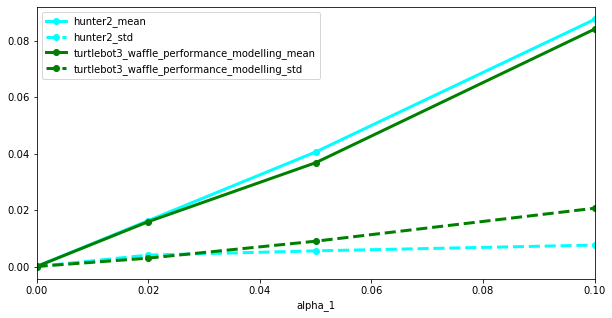

In [7]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.mean().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_mean', color=robot_model_color[robot_model])
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.std().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_std', color=robot_model_color[robot_model], linestyle='dashed')
plt.legend()
plt.show()

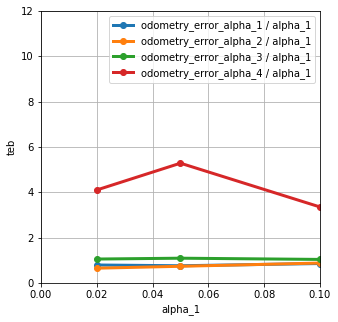

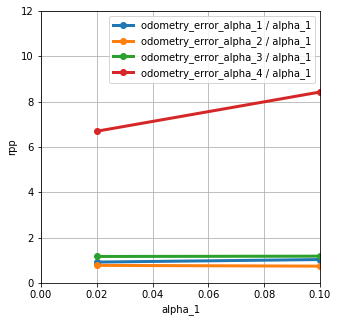

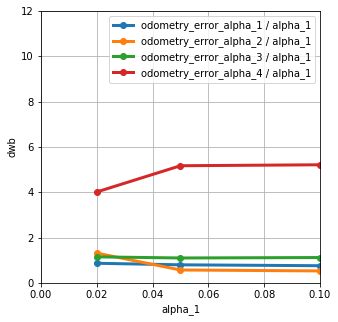

In [8]:
for local_planner_node in df.local_planner_node.unique():
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_1_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_1_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_1 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_2_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_2_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_2 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_3_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_3_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_3 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_4_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_4_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_4 / alpha_1')
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.xlim([0, 0.1])
    plt.ylim([0, 12])
    plt.show()

In [9]:
df.groupby(['robot_model', 'global_planner_node', 'local_planner_node'])[localization_update_translation_mean_metrics].mean().sort_values('localization_update_absolute_translation_error_mean')

localization_update_absolute_translation_error_mean  localization_update_relative_translation_error_mean  localization_update_normalized_relative_translation_error_mean
robot_model                             global_planner_node local_planner_node                                                                                                                                                                          
turtlebot3_waffle_performance_modelling navfn               rpp                                                             0.047                                                0.007                                                0.058             
                                                            dwb                                                             0.074                                                0.008                                                0.038             
hunter2                                 smac                teb                                                             0.074                                                0.010                                                0.032             
turtlebot3_waffle_performance_modelling navfn               teb                                                             0.077                                                0.009                                                0.043             
                                        smac                teb                                                             0.080                                                0.009                                                0.056             
hunter2                                 navfn               teb                                                             0.093                                                0.011                                                0.034

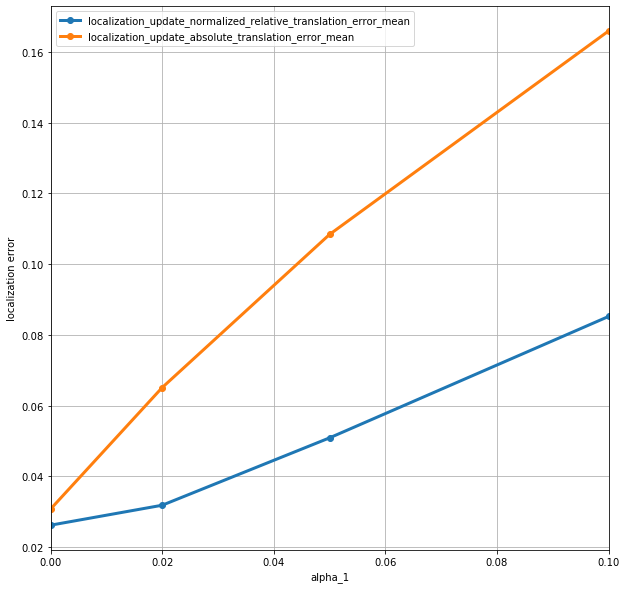

In [10]:
df.groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True)
df.groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True)
plt.legend()
plt.ylabel('localization error')
plt.show()

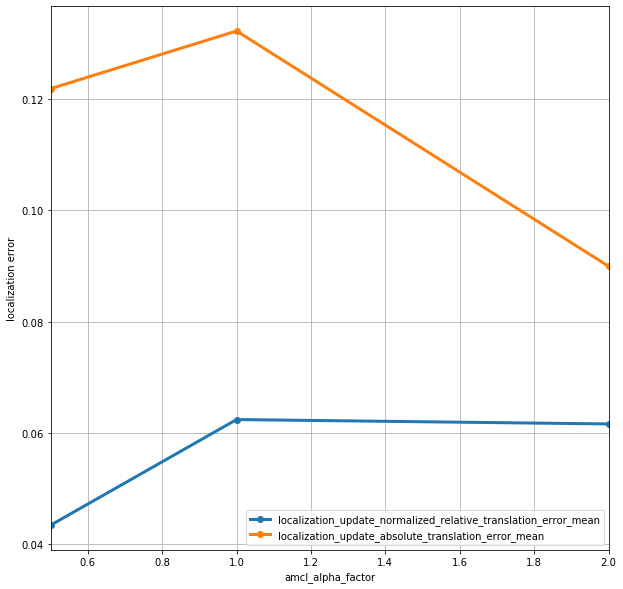

In [11]:
df[df.amcl_alpha_factor > 0].groupby(df.amcl_alpha_factor).localization_update_normalized_relative_translation_error_mean.mean().plot(x='amcl_alpha_factor', grid=True)
df[df.amcl_alpha_factor > 0].groupby(df.amcl_alpha_factor).localization_update_absolute_translation_error_mean.mean().plot(x='amcl_alpha_factor', grid=True)
plt.legend()
plt.ylabel('localization error')
plt.show()

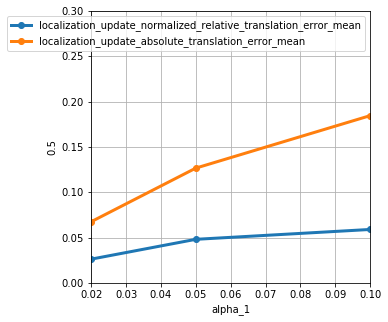

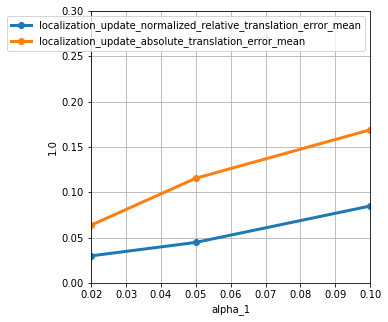

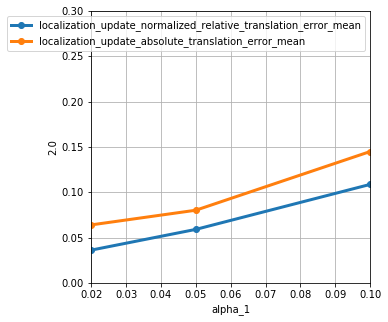

In [12]:
for amcl_alpha_factor in df[df.amcl_alpha_factor > 0].amcl_alpha_factor.unique():
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(amcl_alpha_factor)
    plt.ylim([0, 0.3])
    plt.show()

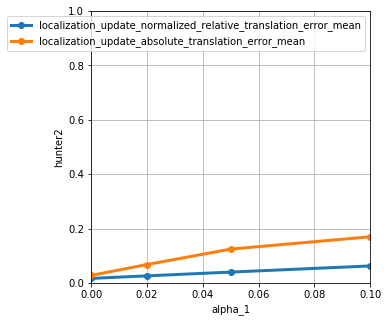

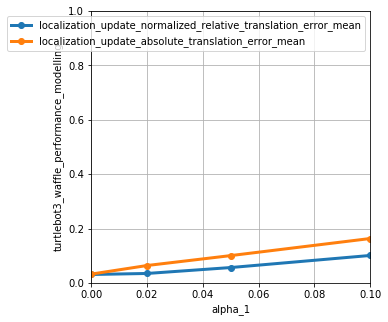

In [13]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(robot_model)
    plt.ylim([0, 1.0])
    plt.show()

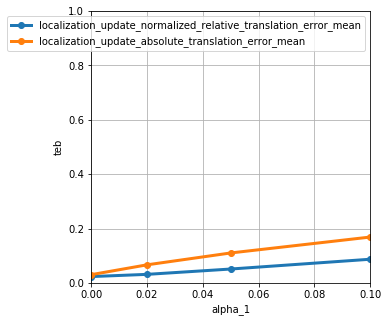

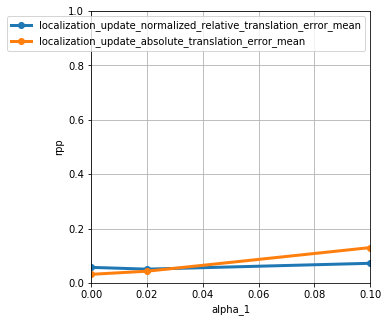

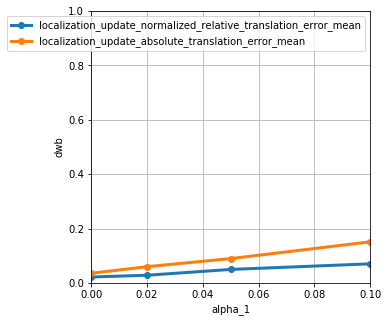

In [14]:
for local_planner_node in df.local_planner_node.unique():
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.ylim([0, 1.0])
    plt.show()

controller_cpu_time       planner_cpu_time       system_cpu_time      
                                                                                              mean count             mean count            mean count
robot_model                             local_planner_node global_planner_node                                                                       
turtlebot3_waffle_performance_modelling rpp                navfn                            27.766     7           26.414     7          65.731     7
                                        dwb                navfn                            53.895    10           39.167    10         108.040    10
hunter2                                 teb                smac                            113.342    26           31.755    26         156.273    26
turtlebot3_waffle_performance_modelling teb                smac                            119.515    44           27.895    44         157.878    44
hunter2                                 teb                navfn                           149.748    29           28.972    29         193.748    29
turtlebot3_waffle_performance_modelling teb                navfn                           148.989    35           33.981    35         196.558    35

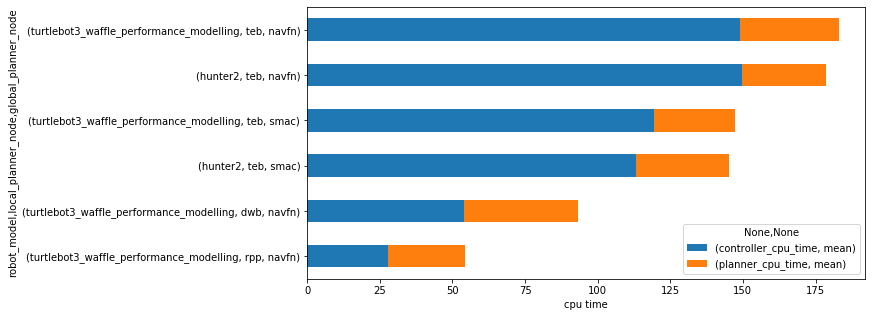

In [20]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[cpu_time_metrics].agg(['mean', 'count']).sort_values(by=('system_cpu_time', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=[('controller_cpu_time', 'mean'), ('planner_cpu_time', 'mean')], stacked=True, figsize=[10, 5],)
ax.set_xlabel("cpu time")
cpu_time_metrics_df

controller_max_memory       planner_max_memory       system_max_memory      
                                                                                                mean count               mean count              mean count
robot_model                             local_planner_node global_planner_node                                                                             
turtlebot3_waffle_performance_modelling dwb                navfn                              32.633    10             60.144    10           217.710    10
                                        rpp                navfn                              26.771     7             68.051     7           229.046     7
                                        teb                smac                               64.117    44             57.077    44           240.784    44
                                                           navfn                              65.446    35             56.513    35           243.165    35
hunter2                                 teb                navfn                              66.012    29             59.198    29           248.948    29
                                                           smac                               64.616    26            891.824    26         1,075.340    26

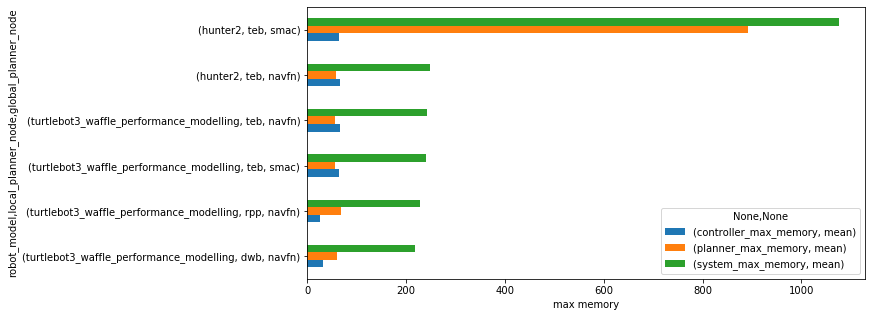

In [19]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[max_memory_metrics].agg(['mean', 'count']).sort_values(by=('system_max_memory', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=[('controller_max_memory', 'mean'), ('planner_max_memory', 'mean'), ('system_max_memory', 'mean')], figsize=[10, 5], legend=True)
ax.set_xlabel("max memory")
cpu_time_metrics_df